In [1]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown
import math

import os
import sys

# if current working directory includes "evaluation" change to parent directory
if "evaluation" in os.getcwd():
    os.chdir("..")
    # Add parent directory to sys.path
    sys.path.append(os.getcwd())



# Verify
print(f"Current working directory: {os.getcwd()}")
print(f"sys.path: {sys.path}")

Current working directory: /root/oxn
sys.path: ['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/root/oxn/venv/lib/python3.11/site-packages', '/root/oxn']


# Short Setup Test

In [2]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation.evaluation as evaluation


importlib.reload(evaluation)

from evaluation.evaluation import Report

assert os.path.exists("reports"), "No reports directory found. Please run the experiments first."

files_in_direcotry = listdir("reports")

# sort them by date
files_in_direcotry.sort(key=lambda x: path.getctime(path.join("reports",x)))

# Load the last experiment
last_experiment = files_in_direcotry[-1]

report_path = path.join("reports", last_experiment.replace(".yaml",".yaml"))
report = Report.from_file(report_path)
print(f"Loaded report {last_experiment}")

assert report is not None, "No report found. Please run the experiments first."
assert isinstance(report, Report), "Report is not of type Report"


assert report.interactions is not None, "No interactions found."
assert report.interactions[0] is not None, "No interactions found. "
assert report.interactions[0].response_data is not None, "No data in interaction found"


Loaded report report_2024-12-09_11-13-44.yaml


Reload evaluation file and caches (mainly for dev)

In [3]:
# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# cache the dataframes
cached_dataframes_kepler_pods = []
cached_dataframes_kepler_namespace = []

In [4]:

# Function to load a report and extract specific interactions
from code import interact


def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        #print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None      
        
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    #print(interaction)
                    #print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    interaction.response_data["report"] = report_name
                    interaction.response_data["label"] = f"{REPORT_LABELS[report_name]}"
                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time

def plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time):

    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get unique container names
    container_names = combined_df["container_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        assert isinstance(ax, plt.Axes)
        container_df = combined_df[combined_df["container_name"] == container_name]

        for treatment, df in container_df.groupby("treatment"):
            #print(df["experiment_seconds"])
            ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel(response_name)
        #ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
        ax.set_xlim(-500, treatment_end_seconds + 500)
        ax.legend()
        ax.grid()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
def plot_kepler_metrics_per_pod_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get unique container names
    container_names = combined_df["container_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Set the style for seaborn
    sns.set(style="whitegrid")
    sns.set_palette("pastel")

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # hue is the list of all unique treatments
    hue = combined_df["treatment"].unique()
    
    # use a lowpass filter to smooth the data
    combined_df[response_name] = combined_df[response_name].rolling(window=6, center=True, min_periods=2).mean()
   
        

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        container_df = combined_df[combined_df["container_name"] == container_name]
        # Interpolate the data for smoothing
        for treatment, df in container_df.groupby("treatment"):
            if len(df) > 1:
                f = interp1d(df["experiment_seconds"], df[response_name], kind='cubic')
                experiment_seconds_new = np.linspace(df["experiment_seconds"].min(), df["experiment_seconds"].max(), num=500)
                response_interpolated = f(experiment_seconds_new)
                sns.lineplot(
                    x=experiment_seconds_new,
                    y=response_interpolated,
                    ax=ax,
                    label=f"{df['label'].iloc[0]}",
                    linewidth=2
                )
            else:
                print(f"Only one data point for {container_name} in treatment {treatment}.")
                """ sns.lineplot(
                    data=df,
                    x="experiment_seconds",
                    y=response_name,
                    ax=ax,
                    label=f"{treatment}",
                    palette="tab10",
                    linewidth=2
                ) """

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel("Watt")
        ax.set_xlim(-500, treatment_end_seconds + 500)
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_kepler_metrics_per_pod_seaborn_with_fill_below(combined_df, response_name, treatment_end_time, treatment_start_time):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get unique container names
    container_names = combined_df["container_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Set the style for seaborn
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        container_df = combined_df[combined_df["container_name"] == container_name]

        # Interpolate the data for smoothing
        for treatment, df in container_df.groupby("treatment"):
            if len(df) > 1:
                f = interp1d(df["experiment_seconds"], df[response_name], kind='cubic')
                experiment_seconds_new = np.linspace(df["experiment_seconds"].min(), df["experiment_seconds"].max(), num=500)
                response_interpolated = f(experiment_seconds_new)
                ax.plot(
                    experiment_seconds_new,
                    response_interpolated,
                    label=f"{treatment}",
                    linewidth=2
                )
                ax.fill_between(
                    experiment_seconds_new,
                    response_interpolated,
                    alpha=0.2
                )
            else:
                sns.lineplot(
                    data=df,
                    x="experiment_seconds",
                    y=response_name,
                    ax=ax,
                    label=f"{treatment}",
                    palette="tab10",
                    linewidth=2
                )
                ax.fill_between(
                    df["experiment_seconds"],
                    df[response_name],
                    alpha=0.3
                )

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel(response_name)
        ax.set_xlim(-500, treatment_end_seconds + 500)
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()

        
def plot_kepler_metrics(combined_df, response_name, treatment_end_time, treatment_start_time, container_namespace):

    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    fig, ax = plt.subplots(figsize=(12, 6))

    

    namespace_df = combined_df[combined_df["container_namespace"] == container_namespace]
    
    # use a lowpass filter to smooth the data
    namespace_df[response_name] = namespace_df[response_name].rolling(window=4).mean()

    #print(namespace_df)

    for treatment, df in namespace_df.groupby("treatment"):
        #print(df["experiment_seconds"])
        ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

    # Add vertical lines for treatment start and end times (normalized)
    ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    ax.set_title(f"Namespace: {container_namespace}")
    ax.set_xlabel("Time (seconds from experiment start)")
    ax.set_ylabel(response_name)
    #ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
    ax.set_xlim(-250, treatment_end_seconds + 250)
    ax.set_ylim(40, 70)
    
    ax.legend()
    ax.grid()

    
    # Adjust layout
    plt.tight_layout()
    plt.show()
   
def plot_kepler_metrics_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time, container_namespace):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
   

    namespace_df = combined_df[combined_df["container_namespace"] == container_namespace]
    
    # use a lowpass filter to smooth the data
    namespace_df[response_name] = namespace_df[response_name].rolling(window=2, center=True, min_periods=1).mean()
    
    

    sns.set_palette("pastel")

    for treatment, df in namespace_df.groupby("treatment"):
        # Interpolate to make it smoother
        x = df["experiment_seconds"]
        y = df[response_name]
        

        f_interpolate = interp1d(x, y, kind='cubic', fill_value='extrapolate')
        x_smooth = np.linspace(x.min(), x.max(), 500)
        y_smooth = f_interpolate(x_smooth)
        
       
        
        sns.lineplot(x=x_smooth, y=y_smooth, label=f"{df['label'].iloc[0]}", ax=ax)
        ax.fill_between(x_smooth, y_smooth, alpha=0.2)

    # Add vertical lines for treatment start and end times (normalized)
    ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    ax.set_title(f"Namespace: {container_namespace}")
    ax.set_xlabel("Time (seconds from fault injection)")
    ax.set_ylabel("Watt")
    ax.set_xlim(-250, treatment_end_seconds + 250)
    ax.set_ylim(50, 90)
    
    ax.legend()
    ax.grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

Loading dataframes from reports because cached dataframes are empty.
Found 0 interactions for report_2024-12-08_16-53-10.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_16-53-10.yaml and empty_treatment.
Found 1 interactions for report_2024-11-27_15-41-31.yaml and delay_treatment.
Found 0 interactions for report_2024-11-27_15-41-31.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_00-14-03.yaml and delay_treatment.
Found 0 interactions for report_2024-11-28_00-14-03.yaml and empty_treatment.
Found 0 interactions for report_2024-12-08_15-06-17.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_15-06-17.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_01-14-14.yaml and delay_treatment.
Found 0 interactions for report_2024-11-28_01-14-14.yaml and empty_treatment.
Found 0 interactions for report_2024-12-08_15-36-23.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_15-36-23.yaml and empty_treatm

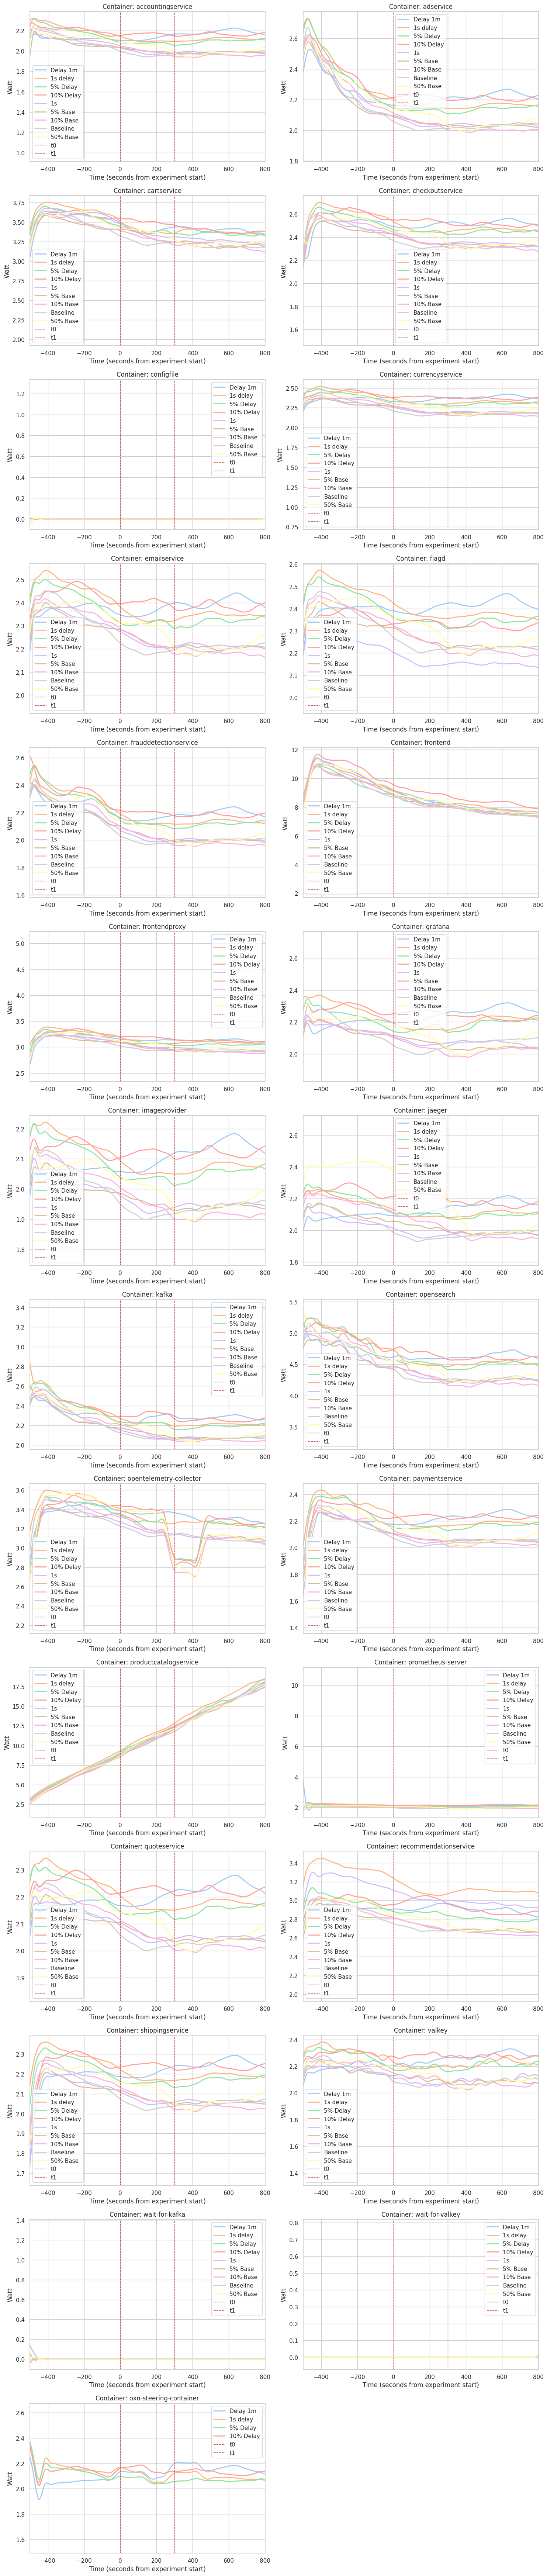

In [5]:

# Directory containing reports
report_directory = "reports/"
treatment_names = ["delay_treatment", "empty_treatment"]
#                       baseline                            delay 1m                            1s  delay                     5% base                         5% delay                                   10% base                             10% delay                     50% base                                    1s
report_names = ["report_2024-12-08_16-53-10.yaml", "report_2024-11-27_15-41-31.yaml", "report_2024-11-28_00-14-03.yaml", "report_2024-12-08_15-06-17.yaml", "report_2024-11-28_01-14-14.yaml",  "report_2024-12-08_15-36-23.yaml", "report_2024-11-28_02-14-27.yaml", "report_2024-12-08_18-06-01.yaml", "report_2024-12-08_14-36-29.yaml"]
REPORT_LABELS = {report_names[0]: "Baseline", report_names[1]: "Delay 1m", report_names[2]: "1s delay", report_names[3]: "5% Base", report_names[4]: "5% Delay", report_names[5]: "10% Base", report_names[6]: "10% Delay",  report_names[7]: "50% Base", report_names[8]: "1s"}

response_name = "pods_kepler_joules_all"

cached_dataframes_kepler_pods, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_dataframes_kepler_pods, report_directory, response_name, treatment_names, report_names)

#plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time)

plot_kepler_metrics_per_pod_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time)

#plot_kepler_metrics_per_pod(report_directory, "recommendationservice_kepler_other_joules_all", treatment_names, report_names)



Loading dataframes from reports because cached dataframes are empty.


Found 0 interactions for report_2024-12-08_16-53-10.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_16-53-10.yaml and empty_treatment.
Found 1 interactions for report_2024-11-27_15-41-31.yaml and delay_treatment.
Found 0 interactions for report_2024-11-27_15-41-31.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_00-14-03.yaml and delay_treatment.
Found 0 interactions for report_2024-11-28_00-14-03.yaml and empty_treatment.
Found 0 interactions for report_2024-12-08_15-06-17.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_15-06-17.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_01-14-14.yaml and delay_treatment.
Found 0 interactions for report_2024-11-28_01-14-14.yaml and empty_treatment.
Found 0 interactions for report_2024-12-08_15-36-23.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_15-36-23.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_02-14-27.yaml and del

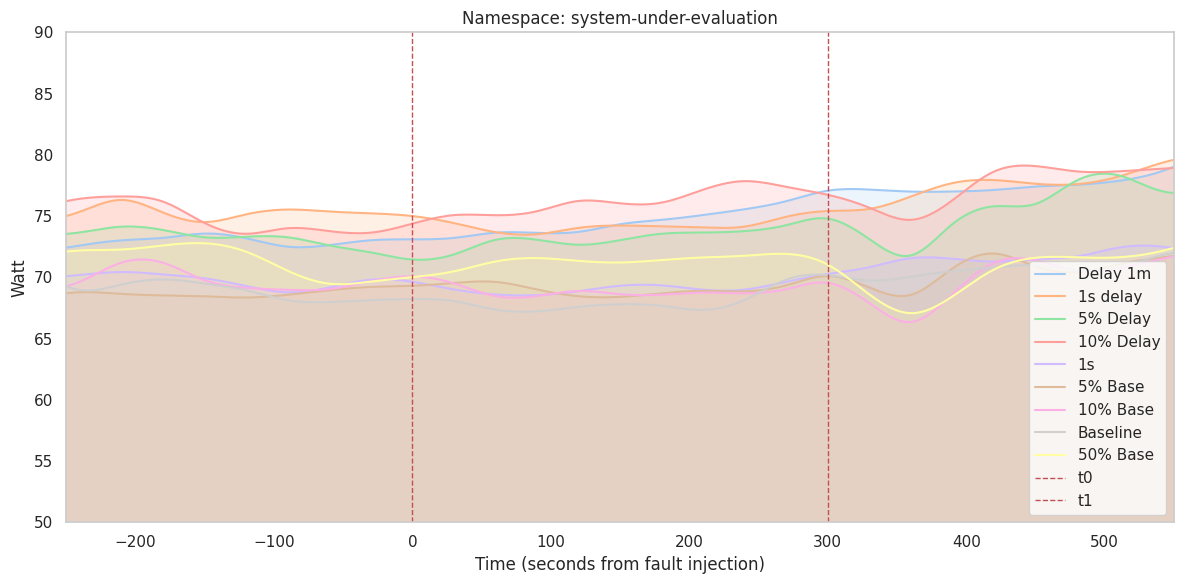

In [6]:
# uncomment to reset cache
cached_dataframes_kepler_namespace = []


response_name = "kepler_joules_namespace_combined"

#                       baseline                            delay 1m                            delay 1s                        5% base                         5% delay                                   10% base                             10% delay                     50% base                                    1s
report_names = ["report_2024-12-08_16-53-10.yaml", "report_2024-11-27_15-41-31.yaml", "report_2024-11-28_00-14-03.yaml", "report_2024-12-08_15-06-17.yaml", "report_2024-11-28_01-14-14.yaml",  "report_2024-12-08_15-36-23.yaml", "report_2024-11-28_02-14-27.yaml", "report_2024-12-08_18-06-01.yaml", "report_2024-12-08_14-36-29.yaml"]
REPORT_LABELS = {report_names[0]: "Baseline", report_names[1]: "Delay 1m", report_names[2]: "1s delay", report_names[3]: "5% Base", report_names[4]: "5% Delay", report_names[5]: "10% Base", report_names[6]: "10% Delay",  report_names[7]: "50% Base", report_names[8]: "1s"}

cached_dataframes_kepler_namespace, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_dataframes_kepler_namespace, report_directory, response_name, treatment_names, report_names)




#plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time)

#plot_kepler_metrics_per_pod(report_directory, "recommendationservice_kepler_other_joules_all", treatment_names, report_names)

#plot_kepler_metrics(combined_df, response_name, treatment_end_time, treatment_start_time, "system-under-evaluation")
plot_kepler_metrics_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time, "system-under-evaluation")



## calculating power consumption per Pod

In [7]:
# Directory containing reports
report_directory = "reports"

report_base = load_report_interactions(report_directory, report_names[0], "pods_kepler_joules_all_absolute", "empty_treatment")
report_delay = load_report_interactions(report_directory, report_names[1], "pods_kepler_joules_all_absolute", "delay_treatment")
report_delay_1s = load_report_interactions(report_directory, report_names[2], "pods_kepler_joules_all_absolute", "delay_treatment")
report_5percent = load_report_interactions(report_directory, report_names[3], "pods_kepler_joules_all_absolute", "empty_treatment")
report_5percent_delay = load_report_interactions(report_directory, report_names[4], "pods_kepler_joules_all_absolute", "delay_treatment")
report_10percent_base = load_report_interactions(report_directory, report_names[5], "pods_kepler_joules_all_absolute", "empty_treatment")
report_10percent_delay = load_report_interactions(report_directory, report_names[6], "pods_kepler_joules_all_absolute", "delay_treatment")
report_50percent_base = load_report_interactions(report_directory, report_names[7], "pods_kepler_joules_all_absolute", "empty_treatment")
report_base_1s = load_report_interactions(report_directory, report_names[8], "pods_kepler_joules_all_absolute", "empty_treatment")

Found 1 interactions for report_2024-12-08_16-53-10.yaml and empty_treatment.


Found 1 interactions for report_2024-11-27_15-41-31.yaml and delay_treatment.
Found 1 interactions for report_2024-11-28_00-14-03.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_15-06-17.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_01-14-14.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_15-36-23.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_02-14-27.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_18-06-01.yaml and empty_treatment.
Found 1 interactions for report_2024-12-08_14-36-29.yaml and empty_treatment.


In [8]:
def get_treatment_start_end(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["container_name"].unique())
    #print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("container_name"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment" and not NoTreatment
        treatment_df = df[df[treatment_name] == treatment_name]

        # cut off the first and last 10% of the data
        treatment_df = df.iloc[int(len(df) * 0.1):int(len(df) * 0.9)]
    
        
        if not treatment_df.empty:
            # TODO: use increase() in prometheus query instead of fixing it here
            # the values are normally monotonic increasing, but there are some exceptions where the values resets to 0 and starts again
            # so we have to check if each following value is greater than the previous one and if not, then we have to add the difference
            
            # Extract the column into a separate series to avoid chained assignment
            column = treatment_df["pods_kepler_joules_all_absolute"].copy()

            # Iterate through the series to fix monotonicity
            for i in range(1, len(column)):
                if column.iloc[i] < column.iloc[i - 1]:
                    print(f"Container: {container_name}, Found break in monotonicity at index {i}. Fixing it.")
                    # Calculate the difference and propagate it to all subsequent values
                    difference = column.iloc[i - 1] - column.iloc[i]
                    column.iloc[i:] += difference

            # Assign the fixed series back to the DataFrame
            treatment_df["pods_kepler_joules_all_absolute"] = column


           # get the first and last value of the treatment
            treatment_start = treatment_df["pods_kepler_joules_all_absolute"].iloc[0]
            treatment_end = treatment_df["pods_kepler_joules_all_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            time_difference = treatment_df.index[-1] - treatment_df.index[0]
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference, time_difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")

    return treatment_start_end_values



def modify_treatment(report, report_name, treatment_name):
    """if report:
        # Add treatment information to the DataFrame
        report.response_data["treatment"] = f"{report_name}_{treatment_name}"
        report.response_data["treatment_start"] = report.treatment_start
        report.response_data["treatment_end"] = report.treatment_end """
    return report


# Example usage
treatment_start_end = {}

report_base_interaction_modified = modify_treatment(report_base, report_names[0], "empty_treatment")
report_delay_interaction_modified = modify_treatment(report_delay, report_names[1], "delay_treatment")
report_delay_1s_interaction_modified = modify_treatment(report_delay_1s, report_names[2], "delay_treatment")
report_5percent_interaction_modified = modify_treatment(report_5percent, report_names[3], "empty_treatment")
report_5percent_delay_interaction_modified = modify_treatment(report_5percent_delay, report_names[4], "delay_treatment")
report_10percent_base_interaction_modified = modify_treatment(report_10percent_base, report_names[5], "empty_treatment")
report_10percent_delay_interaction_modified = modify_treatment(report_10percent_delay, report_names[6], "delay_treatment")
report_50percent_base_interaction_modified = modify_treatment(report_50percent_base, report_names[7], "empty_treatment")
report_1s_base_interaction_modified = modify_treatment(report_base_1s, report_names[8], "empty_treatment")

treatment_start_end_base = get_treatment_start_end(report_base_interaction_modified, "empty_treatment")
treatment_start_end_delay = get_treatment_start_end(report_delay_interaction_modified, "delay_treatment")
treatment_start_end_delay_1s = get_treatment_start_end(report_delay_1s_interaction_modified, "delay_treatment")
treatment_start_end_5percent = get_treatment_start_end(report_5percent_interaction_modified, "empty_treatment")
treatment_start_end_5percent_delay = get_treatment_start_end(report_5percent_delay_interaction_modified, "delay_treatment")
treatment_start_end_10percent_base = get_treatment_start_end(report_10percent_base_interaction_modified, "empty_treatment")
treatment_start_end_10percent_delay = get_treatment_start_end(report_10percent_delay_interaction_modified, "delay_treatment")
treatment_start_end_50percent_base = get_treatment_start_end(report_50percent_base_interaction_modified, "empty_treatment")
treatment_start_end_base_1s = get_treatment_start_end(report_1s_base_interaction_modified, "empty_treatment")

for container_name, values in treatment_start_end_base.items():
    percentage_differece_delay = (treatment_start_end_delay[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_differece_delay_1s = (treatment_start_end_delay_1s[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_differece_5percent = (treatment_start_end_5percent[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percecntage_differece_5percent_delay = (treatment_start_end_5percent_delay[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_difference_10percent_base = (treatment_start_end_10percent_base[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_differece_10percent_delay = (treatment_start_end_10percent_delay[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_difference_50percent_base = (treatment_start_end_50percent_base[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_difference_base_1s = (treatment_start_end_base_1s[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    print(f"Container: {container_name}")
    print(f"Base Treatment: {treatment_start_end_base[container_name][2]} over {treatment_start_end_base[container_name][3]}")
    print(f"Delay Treatment: {treatment_start_end_delay[container_name][2]} ({percentage_differece_delay:.2f}%) over {treatment_start_end_delay[container_name][3]}")
    print(f"1s Treatment: {treatment_start_end_base_1s[container_name][2]} ({percentage_difference_base_1s:.2f}%) over {treatment_start_end_base_1s[container_name][3]}")
    print(f"Delay 1s Treatment: {treatment_start_end_delay_1s[container_name][2]} ({percentage_differece_delay_1s:.2f}%) over {treatment_start_end_delay_1s[container_name][3]}")
    print(f"5% Treatment: {treatment_start_end_5percent[container_name][2]} ({percentage_differece_5percent:.2f}%) over {treatment_start_end_5percent[container_name][3]}")
    print(f"5% Delay Treatment: {treatment_start_end_5percent_delay[container_name][2]} ({percecntage_differece_5percent_delay:.2f}%) over {treatment_start_end_5percent_delay[container_name][3]}")
    print(f"10% Treatment: {treatment_start_end_10percent_base[container_name][2]} ({percentage_difference_10percent_base:.2f}%) over {treatment_start_end_10percent_base[container_name][3]}")
    print(f"10% Delay Treatment: {treatment_start_end_10percent_delay[container_name][2]} ({percentage_differece_10percent_delay:.2f}%) over {treatment_start_end_10percent_delay[container_name][3]}")
    print(f"50% Treatment: {treatment_start_end_50percent_base[container_name][2]} ({percentage_difference_50percent_base:.2f}%) over {treatment_start_end_50percent_base[container_name][3]}")
    print("-----------------------------------------------")
        
base_sum = sum([treatment_start_end_base[container_name][2] for container_name in treatment_start_end_base])
delay_sum = sum([treatment_start_end_delay[container_name][2] for container_name in treatment_start_end_delay])
delay_1s_sum = sum([treatment_start_end_delay_1s[container_name][2] for container_name in treatment_start_end_delay_1s])
percent_5_sum = sum([treatment_start_end_5percent[container_name][2] for container_name in treatment_start_end_5percent])
percent_5_delay_sum = sum([treatment_start_end_5percent_delay[container_name][2] for container_name in treatment_start_end_5percent_delay])
percent_10_sum = sum([treatment_start_end_10percent_base[container_name][2] for container_name in treatment_start_end_10percent_base])
percent_10_delay_sum = sum([treatment_start_end_10percent_delay[container_name][2] for container_name in treatment_start_end_10percent_delay])
percent_50_sum = sum([treatment_start_end_50percent_base[container_name][2] for container_name in treatment_start_end_50percent_base])
percent_1s_sum = sum([treatment_start_end_base_1s[container_name][2] for container_name in treatment_start_end_base_1s])

print(f"All containers:")
print(f"Base Treatment: {base_sum}")
print(f"Delay Treatment: {delay_sum} ({(delay_sum - base_sum) / base_sum * 100:.2f}%)")
print(f"1s Treatment: {percent_1s_sum} ({(percent_1s_sum - base_sum) / base_sum * 100:.2f}%)")
print(f"Delay 1s Treatment: {delay_1s_sum} ({(delay_1s_sum - base_sum) / base_sum * 100:.2f}%)")
print(f"5% Treatment: {percent_5_sum} ({(percent_5_sum - base_sum) / base_sum * 100:.2f}%)")
print(f"5% Delay Treatment: {percent_5_delay_sum} ({(percent_5_delay_sum - base_sum) / base_sum * 100:.2f}%)")
print(f"10% Treatment: {percent_10_sum} ({(percent_10_sum - base_sum) / base_sum * 100:.2f}%)")
print(f"10% Delay Treatment: {percent_10_delay_sum} ({(percent_10_delay_sum - base_sum) / base_sum * 100:.2f}%)")
print(f"50% Treatment: {percent_50_sum} ({(percent_50_sum - base_sum) / base_sum * 100:.2f}%)")
print("-----------------------------------------------")

# calc median, average and percentlies of all containers

base_values = [treatment_start_end_base[container_name][2] for container_name in treatment_start_end_base]
delay_values = [treatment_start_end_delay[container_name][2] for container_name in treatment_start_end_delay]
base_1s_values = [treatment_start_end_base_1s[container_name][2] for container_name in treatment_start_end_base_1s]
delay_1s_values = [treatment_start_end_delay_1s[container_name][2] for container_name in treatment_start_end_delay_1s]
percent_5_values = [treatment_start_end_5percent[container_name][2] for container_name in treatment_start_end_5percent]
percent_5_delay_values = [treatment_start_end_5percent_delay[container_name][2] for container_name in treatment_start_end_5percent_delay]
percent_10_values = [treatment_start_end_10percent_base[container_name][2] for container_name in treatment_start_end_10percent_base]
percent_10_delay_values = [treatment_start_end_10percent_delay[container_name][2] for container_name in treatment_start_end_10percent_delay]
percent_50_values = [treatment_start_end_50percent_base[container_name][2] for container_name in treatment_start_end_50percent_base]


print(f"Base Treatment: Median: {np.median(base_values)}, Average: {np.mean(base_values)}, 90th percentile: {np.percentile(base_values, 90)}")
print(f"Delay Treatment: Median: {np.median(delay_values)}, Average: {np.mean(delay_values)}, 90th percentile: {np.percentile(delay_values, 90)}")
print(f"1s Treatment: Median: {np.median(base_1s_values)}, Average: {np.mean(base_1s_values)}, 90th percentile: {np.percentile(base_1s_values, 90)}")
print(f"Delay 1s Treatment: Median: {np.median(delay_1s_values)}, Average: {np.mean(delay_1s_values)}, 90th percentile: {np.percentile(delay_1s_values, 90)}")
print(f"5% Treatment: Median: {np.median(percent_5_values)}, Average: {np.mean(percent_5_values)}, 90th percentile: {np.percentile(percent_5_values, 90)}")
print(f"5% Delay Treatment: Median: {np.median(percent_5_delay_values)}, Average: {np.mean(percent_5_delay_values)}, 90th percentile: {np.percentile(percent_5_delay_values, 90)}")
print(f"10% Treatment: Median: {np.median(percent_10_values)}, Average: {np.mean(percent_10_values)}, 90th percentile: {np.percentile(percent_10_values, 90)}")
print(f"10% Delay Treatment: Median: {np.median(percent_10_delay_values)}, Average: {np.mean(percent_10_delay_values)}, 90th percentile: {np.percentile(percent_10_delay_values, 90)}")
print(f"50% Treatment: Median: {np.median(percent_50_values)}, Average: {np.mean(percent_50_values)}, 90th percentile: {np.percentile(percent_50_values, 90)}")

print("-----------------------------------------------")

# variance and error
print(f"Base Treatment: Variance: {np.var(base_values)}, Standard deviation: {np.std(base_values)}, Standard error: {np.std(base_values) / np.sqrt(len(base_values))}")
print(f"Delay Treatment: Variance: {np.var(delay_values)}, Standard deviation: {np.std(delay_values)}, Standard error: {np.std(delay_values) / np.sqrt(len(delay_values))}")
print(f"1s Treatment: Variance: {np.var(base_1s_values)}, Standard deviation: {np.std(base_1s_values)}, Standard error: {np.std(base_1s_values) / np.sqrt(len(base_1s_values))}")
print(f"Delay 1s Treatment: Variance: {np.var(delay_1s_values)}, Standard deviation: {np.std(delay_1s_values)}, Standard error: {np.std(delay_1s_values) / np.sqrt(len(delay_1s_values))}")
print(f"5% Treatment: Variance: {np.var(percent_5_values)}, Standard deviation: {np.std(percent_5_values)}, Standard error: {np.std(percent_5_values) / np.sqrt(len(percent_5_values))}")
print(f"5% Delay Treatment: Variance: {np.var(percent_5_delay_values)}, Standard deviation: {np.std(percent_5_delay_values)}, Standard error: {np.std(percent_5_delay_values) / np.sqrt(len(percent_5_delay_values))}")
print(f"10% Treatment: Variance: {np.var(percent_10_values)}, Standard deviation: {np.std(percent_10_values)}, Standard error: {np.std(percent_10_values) / np.sqrt(len(percent_10_values))}")
print(f"10% Delay Treatment: Variance: {np.var(percent_10_delay_values)}, Standard deviation: {np.std(percent_10_delay_values)}, Standard error: {np.std(percent_10_delay_values) / np.sqrt(len(percent_10_delay_values))}")
print(f"50% Treatment: Variance: {np.var(percent_50_values)}, Standard deviation: {np.std(percent_50_values)}, Standard error: {np.std(percent_50_values) / np.sqrt(len(percent_50_values))}")


print("-----------------------------------------------")

# in kWh
base_sum_kwh = base_sum / 3600000
base_1s_sum_kwh = percent_1s_sum / 3600000
percent_10_sum_kwh = percent_10_sum / 3600000
percent_50_sum_kwh = percent_50_sum / 3600000

print(f"Base Treatment: {base_sum_kwh} kWh")
print(f"1s Treatment: {base_1s_sum_kwh} kWh")
print(f"10% Treatment: {percent_10_sum_kwh} kWh")
print(f"50% Treatment: {percent_50_sum_kwh} kWh")


Container: opentelemetry-collector, Found break in monotonicity at index 27. Fixing it.
Container: opentelemetry-collector, Found break in monotonicity at index 27. Fixing it.
Container: opentelemetry-collector, Found break in monotonicity at index 27. Fixing it.
Container: opentelemetry-collector, Found break in monotonicity at index 27. Fixing it.
Container: opentelemetry-collector, Found break in monotonicity at index 27. Fixing it.
Container: accountingservice
Base Treatment: 2424.7110000000002 over 0 days 00:20:00
Delay Treatment: 2512.446 (3.62%) over 0 days 00:19:30
1s Treatment: 2427.516 (0.12%) over 0 days 00:20:00
Delay 1s Treatment: 2579.4809999999998 (6.38%) over 0 days 00:20:00
5% Treatment: 2426.88 (0.09%) over 0 days 00:20:00
5% Delay Treatment: 2545.416 (4.98%) over 0 days 00:20:00
10% Treatment: 2431.839 (0.29%) over 0 days 00:20:00
10% Delay Treatment: 2610.777 (7.67%) over 0 days 00:20:00
50% Treatment: 2400.1169999999997 (-1.01%) over 0 days 00:19:30
---------------

/tmp/ipykernel_2136055/233438589.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["pods_kepler_joules_all_absolute"] = column
/tmp/ipykernel_2136055/233438589.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["pods_kepler_joules_all_absolute"] = column
/tmp/ipykernel_2136055/233438589.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

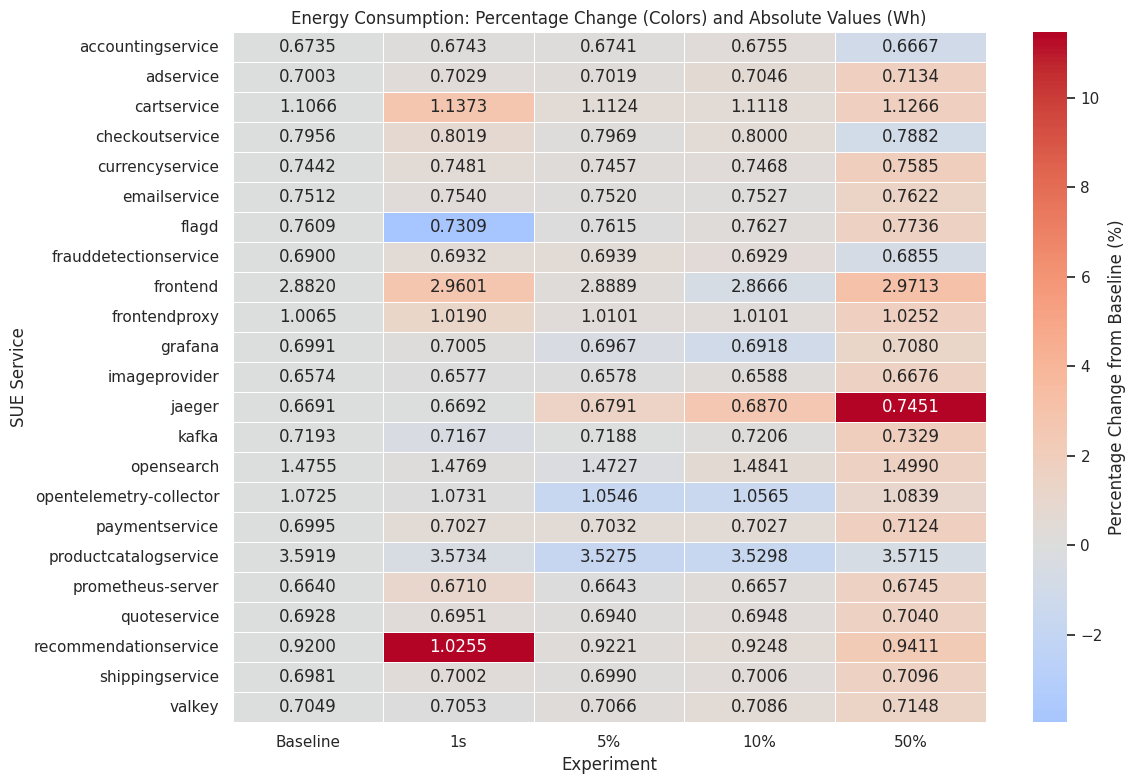

                          Baseline         1s         5%        10%        50%
accountingservice         2424.711   2427.516   2426.880   2431.839   2400.117
adservice                 2520.996   2530.419   2526.846   2536.569   2568.402
cartservice               3983.940   4094.247   4004.652   4002.456   4055.712
checkoutservice           2864.163   2886.783   2868.672   2879.970   2837.472
configfile                   0.000      0.000      0.000      0.000      0.000
currencyservice           2679.081   2693.280   2684.682   2688.528   2730.762
emailservice              2704.434   2714.346   2707.134   2709.855   2744.028
flagd                     2739.381   2631.195   2741.334   2745.591   2785.122
frauddetectionservice     2484.111   2495.547   2497.866   2494.389   2467.782
frontend                 10375.137  10656.408  10400.181  10319.760  10696.683
frontendproxy             3623.424   3668.580   3636.330   3636.465   3690.687
grafana                   2516.883   2521.935   2508

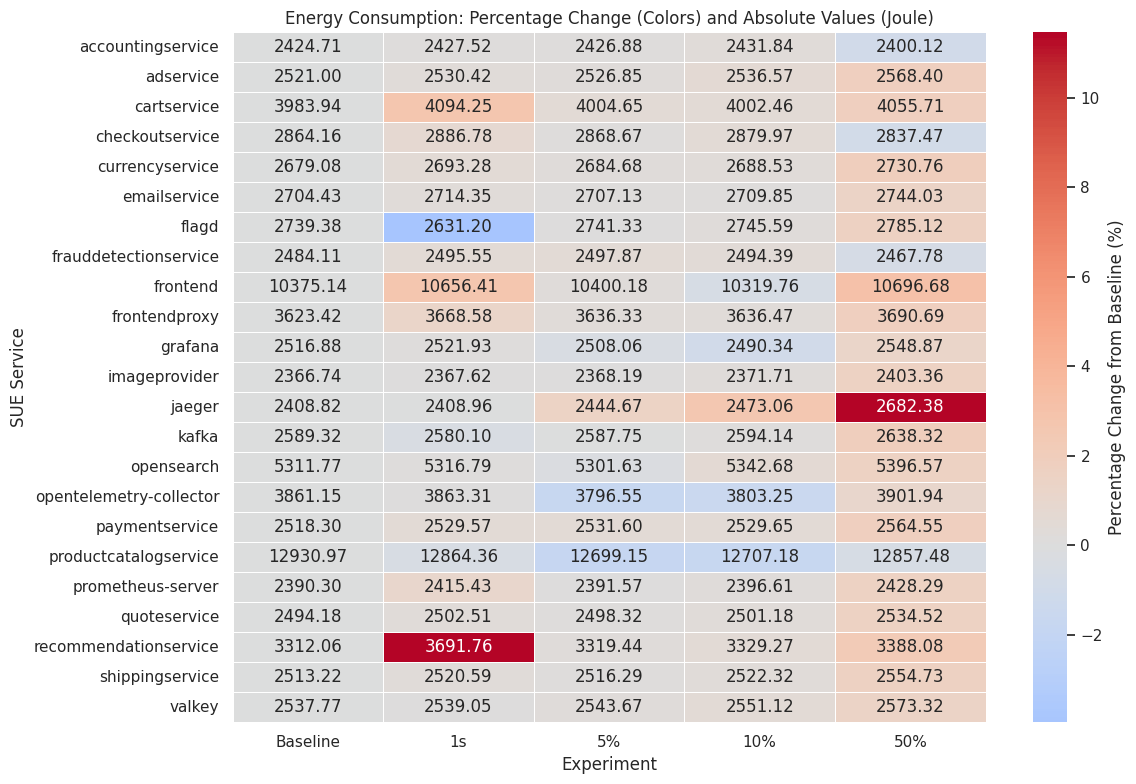

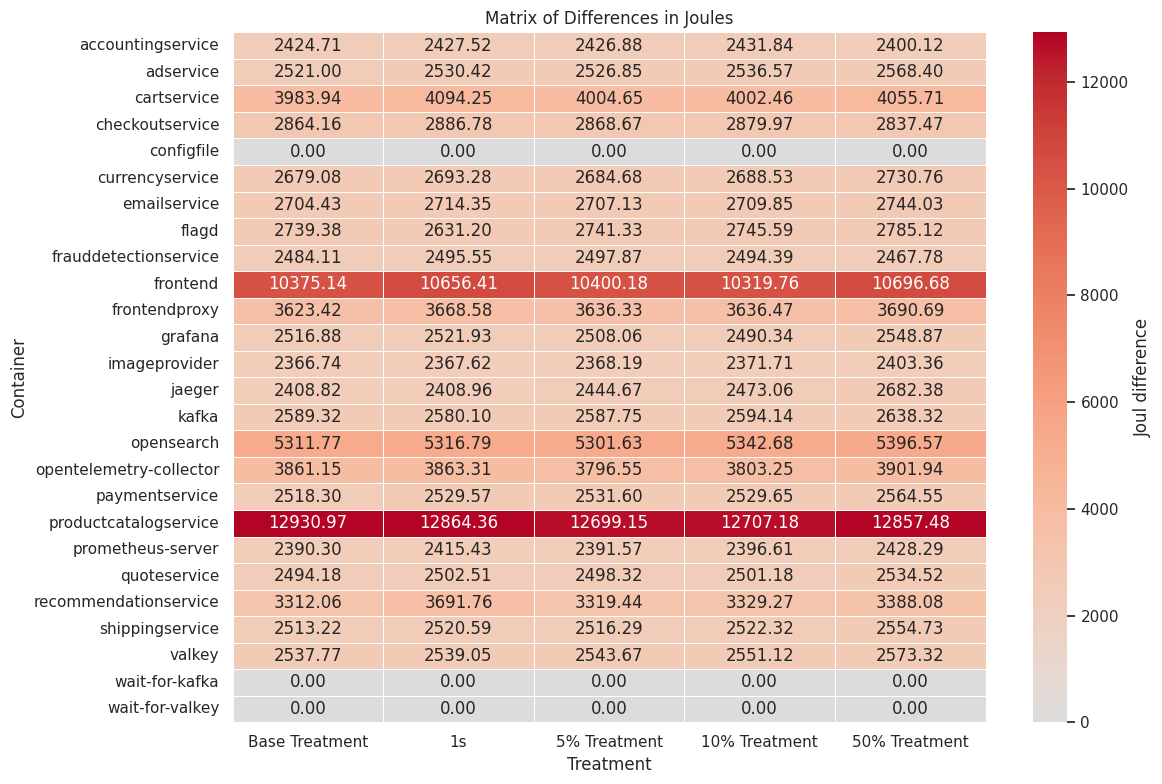

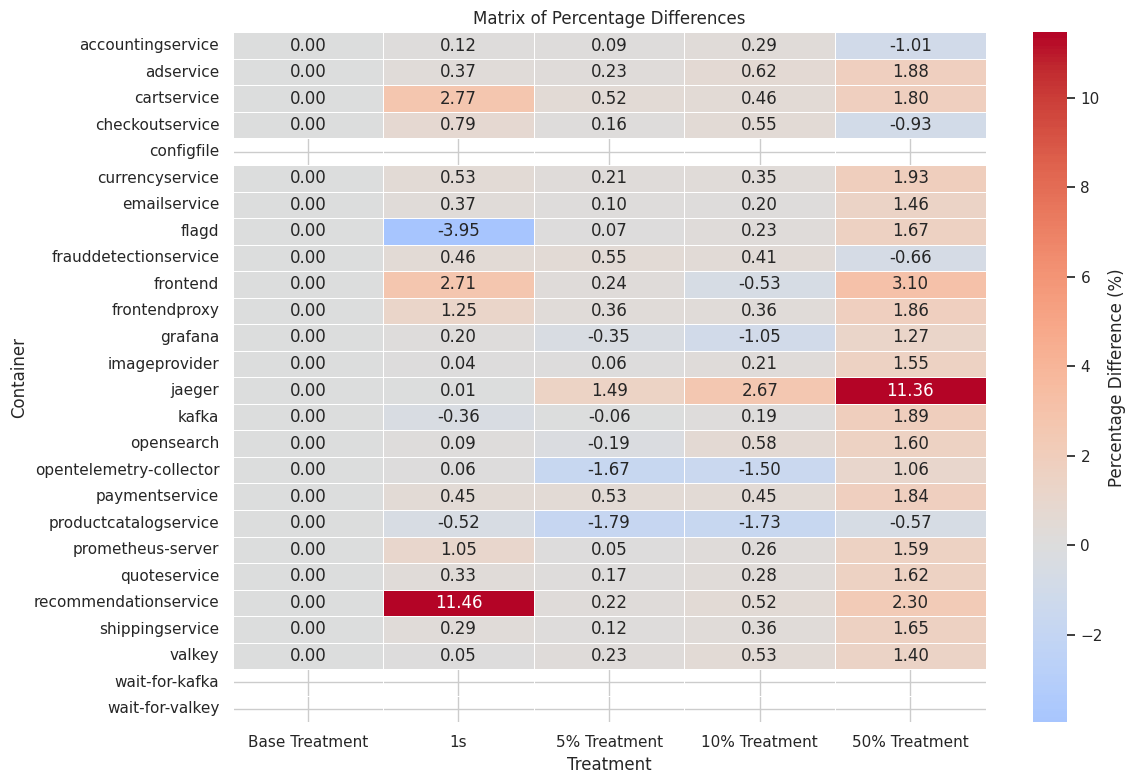

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_difference_matrix_percentage(
    treatment_start_end_base, 
    treatment_start_end_delay, 
    treatment_start_end_1s,
    treatment_start_end_delay_1s, 
    treatment_start_end_5percent, 
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base
    ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers],
        #"Delay Treatment": [treatment_start_end_delay[c][2] for c in containers],
        "1s": [treatment_start_end_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        #"Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers],
        #"5% Delay Treatment": [treatment_start_end_5percent_delay[c][2] for c in containers],
        "10% Treatment": [treatment_start_end_10percent_base[c][2] for c in containers],
        #"10% Delay Treatment": [treatment_start_end_10percent_delay[c][2] for c in containers],
        "50% Treatment": [treatment_start_end_50percent_base[c][2] for c in containers]
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in data.keys():
        percentage_difference[col] = (df[col] - df["Base Treatment"]) / df["Base Treatment"] * 100

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Matrix of Percentage Differences")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

def generate_difference_matrix(
    treatment_start_end_base, 
    treatment_start_end_delay, 
    treatment_start_end_1s,
    treatment_start_end_delay_1s, 
    treatment_start_end_5percent, 
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base, 
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base
    ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers],
        #"Delay Treatment": [treatment_start_end_delay[c][2] for c in containers],
        "1s": [treatment_start_end_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        #"Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers],
        #"5% Delay Treatment": [treatment_start_end_5percent_delay[c][2] for c in containers],
        "10% Treatment": [treatment_start_end_10percent_base[c][2] for c in containers],
        #"10% Delay Treatment": [treatment_start_end_10percent_delay[c][2] for c in containers],
        "50% Treatment": [treatment_start_end_50percent_base[c][2] for c in containers]
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in data.keys():
        percentage_difference[col] = df[col]

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Joul difference'}
    )
    plt.title("Matrix of Differences in Joules")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

def generate_difference_matrix_baseline(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_1s,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_delay_5percent,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        #"Delay": [treatment_start_end_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "1s": [treatment_start_end_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        #"Delay 1s": [treatment_start_end_delay_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "5%": [treatment_start_end_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        #"Delay 5% ": [treatment_start_end_delay_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "10%": [treatment_start_end_10percent_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        #"Delay 10%": [treatment_start_end_10percent_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "50%": [treatment_start_end_50percent_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent]
    }

    for c in containers:
        if c not in treatment_start_end_delay or c not in treatment_start_end_delay_1s or c not in treatment_start_end_5percent:
            print(f"Container {c} not found in all treatments. removing from list.")
            containers.remove(c)
            continue

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)


    # Compute percentage changes relative to "Baseline"
    percentage_changes = df.subtract(df["Baseline"], axis=0).div(df["Baseline"], axis=0) * 100

    # Compute absolute differences (to show as annotations)
    absolute_difference = df.subtract(df["Baseline"], axis=0)

    #print(percentage_changes)
    print(df)
    
    df = df #/ (3600 * 1000) # convert to kWh

    #check if there are any infinite values 
    for col in percentage_changes.columns:
        for i in range(len(percentage_changes[col])):
            if math.isinf(percentage_changes[col].iloc[i]):
                print(f"NaN found in {col} {i} with value {percentage_changes[col].iloc[i]} for original values {df[col].iloc[i]} and {df['Baseline'].iloc[i]}")
                percentage_changes.loc[containers[i], col] = math.nan
    

    percentage_changes = percentage_changes.dropna()
    df = [df.loc[container] for container in percentage_changes.index]
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df,  # Absolutes are shown as annotations
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Change from Baseline (%)'}
    )
    plt.title("Energy Consumption: Percentage Change (Colors) and Absolute Values (Joule)")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    plt.savefig("evaluation/plots/energy_consumption_heatmap.png")
    plt.show()
    
def generate_difference_matrix_baseline_kwh(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_1s,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_delay_5percent,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        #"Delay": [treatment_start_end_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "1s": [treatment_start_end_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        #"Delay 1s": [treatment_start_end_delay_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "5%": [treatment_start_end_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        #"Delay 5% ": [treatment_start_end_delay_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "10%": [treatment_start_end_10percent_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        #"Delay 10%": [treatment_start_end_10percent_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "50%": [treatment_start_end_50percent_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent]
    }

    for c in containers:
        if c not in treatment_start_end_delay or c not in treatment_start_end_delay_1s or c not in treatment_start_end_5percent:
            print(f"Container {c} not found in all treatments. removing from list.")
            containers.remove(c)
            continue

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)


    # Compute percentage changes relative to "Baseline"
    percentage_changes = df.subtract(df["Baseline"], axis=0).div(df["Baseline"], axis=0) * 100

    # Compute absolute differences (to show as annotations)
    absolute_difference = df.subtract(df["Baseline"], axis=0)

    #print(percentage_changes)
    #print(df)
    
    df = df #/ (3600 * 1000) # convert to kWh

    #check if there are any infinite values 
    for col in percentage_changes.columns:
        for i in range(len(percentage_changes[col])):
            if math.isinf(percentage_changes[col].iloc[i]):
                print(f"NaN found in {col} {i} with value {percentage_changes[col].iloc[i]} for original values {df[col].iloc[i]} and {df['Baseline'].iloc[i]}")
                percentage_changes.loc[containers[i], col] = math.nan
    
    df_wh = df / 3600
    df_kwh = df / (3600 * 1000) # convert to kWh
    

    # remove empty containers
    percentage_changes = percentage_changes.dropna()
    df_wh = [df_wh.loc[container] for container in percentage_changes.index]
    df_kwh = [df_kwh.loc[container] for container in percentage_changes.index]

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df_wh,  # Absolutes are shown as annotations
        fmt=".4f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Change from Baseline (%)'}
    )
    plt.title("Energy Consumption: Percentage Change (Colors) and Absolute Values (Wh)")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    plt.savefig("evaluation/plots/energy_consumption_heatmap_kwh.png")
    plt.show()

generate_difference_matrix_baseline_kwh(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_base_1s,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base   
)

generate_difference_matrix_baseline(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_base_1s,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base
)

generate_difference_matrix(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_base_1s,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base
)

generate_difference_matrix_percentage(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_base_1s,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay,
    treatment_start_end_50percent_base
)


                          Baseline  5% No Treatment
accountingservice         2424.711         2426.880
adservice                 2520.996         2526.846
cartservice               3983.940         4004.652
checkoutservice           2864.163         2868.672
configfile                   0.000            0.000
currencyservice           2679.081         2684.682
emailservice              2704.434         2707.134
flagd                     2739.381         2741.334
frauddetectionservice     2484.111         2497.866
frontend                 10375.137        10400.181
frontendproxy             3623.424         3636.330
grafana                   2516.883         2508.063
imageprovider             2366.742         2368.188
jaeger                    2408.820         2444.667
kafka                     2589.321         2587.752
opensearch                5311.770         5301.627
opentelemetry-collector   3861.153         3796.548
paymentservice            2518.302         2531.598
productcatal

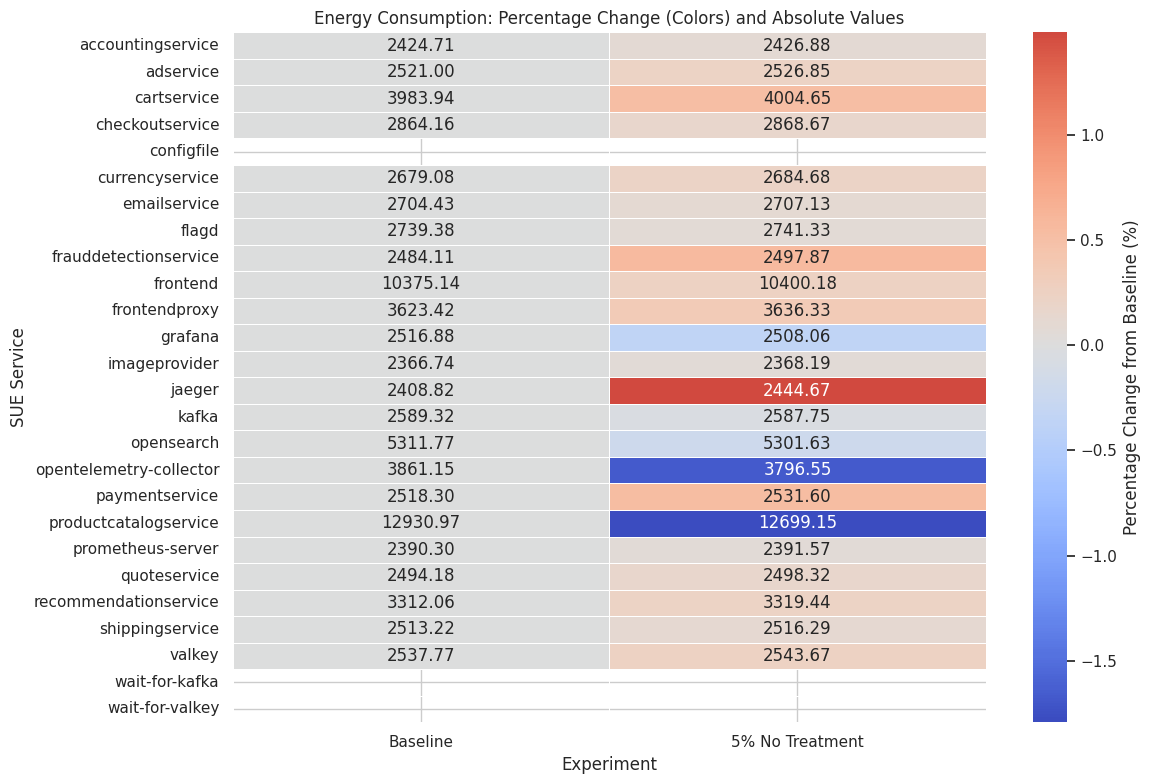

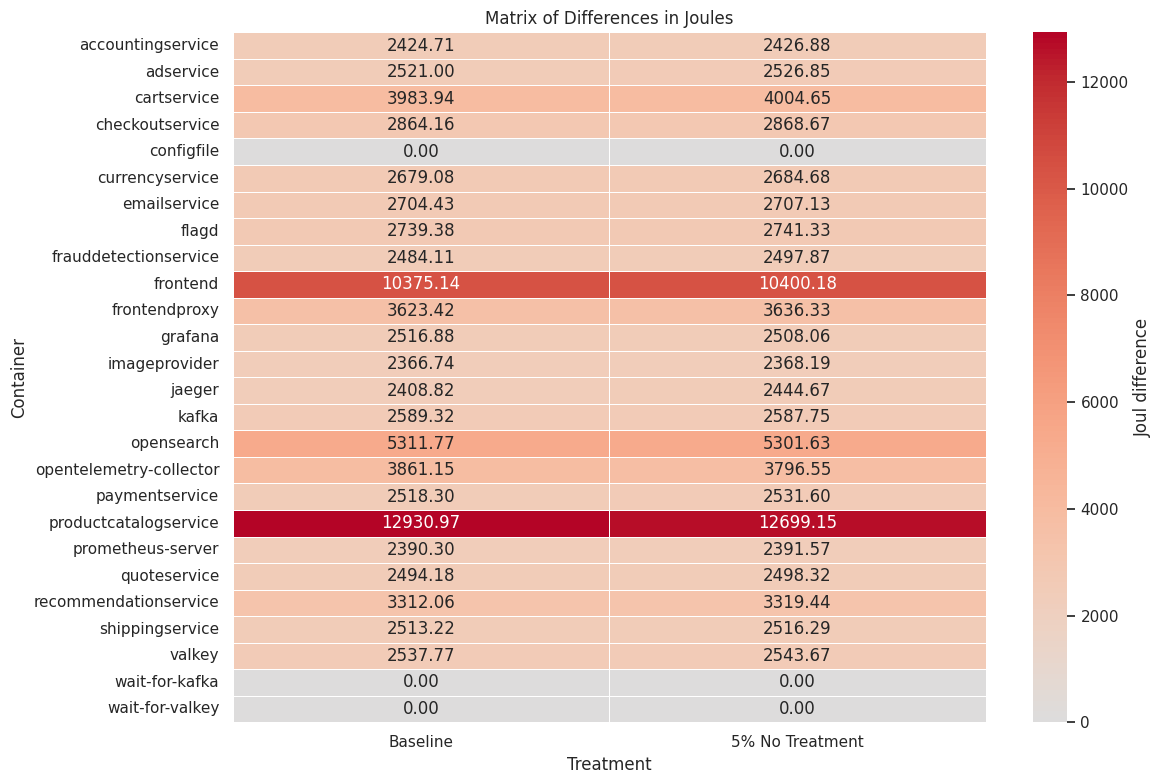

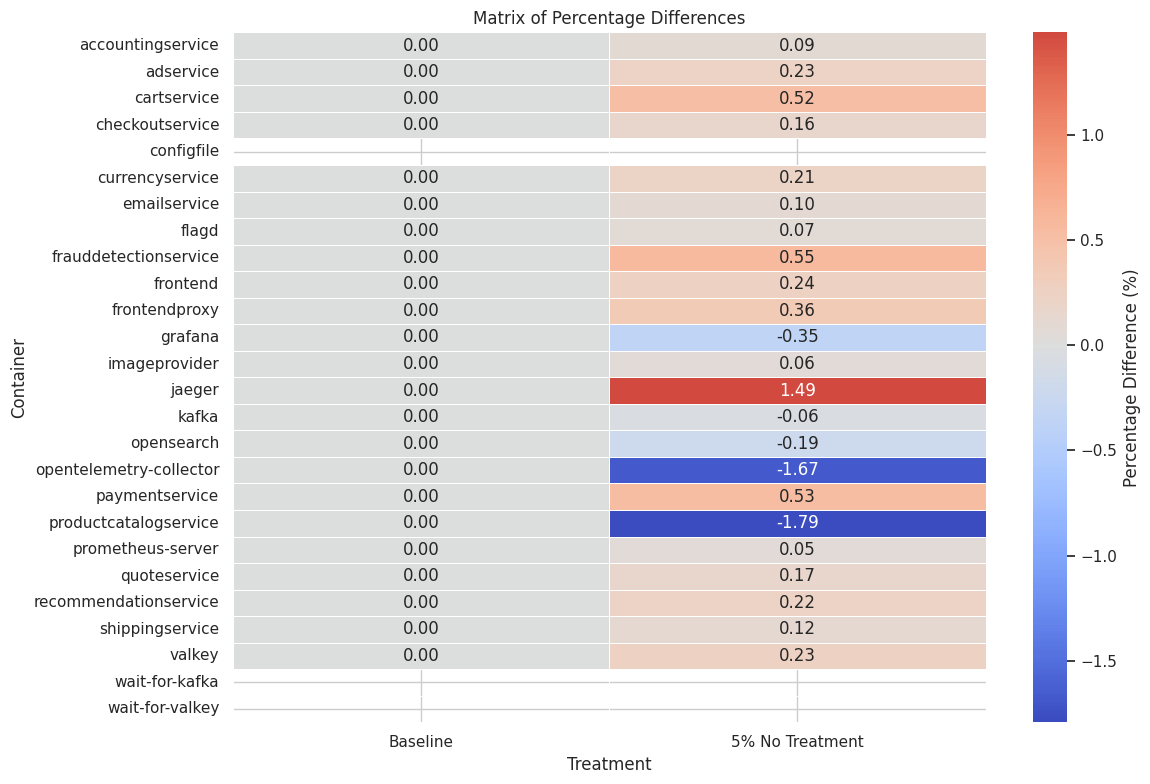

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_difference_matrix_percentage(
    treatment_start_end_base, 
    treatment_start_end_delay, 
    treatment_start_end_delay_1s, 
    treatment_start_end_5percent, 
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay
    ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        "5% No Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in ["Baseline", "5% No Treatment"]:
        percentage_difference[col] = (df[col] - df["Baseline"]) / df["Baseline"] * 100

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Matrix of Percentage Differences")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

def generate_difference_matrix(
    treatment_start_end_base, 
    treatment_start_end_delay, 
    treatment_start_end_delay_1s, 
    treatment_start_end_5percent, 
    treatment_start_end_5percent_delay,
    treatment_start_end_10percent_base, 
    treatment_start_end_10percent_delay
    ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        "5% No Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in ["Baseline", "5% No Treatment"]:
        percentage_difference[col] = df[col]

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Joul difference'}
    )
    plt.title("Matrix of Differences in Joules")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

def generate_difference_matrix_baseline(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_delay_5percent,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers],
        "5% No Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    for c in containers:
        if c not in treatment_start_end_5percent:
            print(f"Container {c} not found in all treatments. removing from list.")
            containers.remove(c)
            continue

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)


    # Compute percentage changes relative to "Baseline"
    percentage_changes = df.subtract(df["Baseline"], axis=0).div(df["Baseline"], axis=0) * 100

    # Compute absolute differences (to show as annotations)
    absolute_difference = df.subtract(df["Baseline"], axis=0)

    #print(percentage_changes)
    print(df)
    
    df = df #/ (3600 * 1000) # convert to kWh

    #check if there are any infinite values 
    for col in percentage_changes.columns:
        for i in range(len(percentage_changes[col])):
            if math.isinf(percentage_changes[col].iloc[i]):
                print(f"NaN found in {col} {i} with value {percentage_changes[col].iloc[i]} for original values {df[col].iloc[i]} and {df['Baseline'].iloc[i]}")
                percentage_changes.loc[containers[i], col] = math.nan
    

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df,  # Absolutes are shown as annotations
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Change from Baseline (%)'}
    )
    plt.title("Energy Consumption: Percentage Change (Colors) and Absolute Values")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    plt.show()


generate_difference_matrix_baseline(
    treatment_start_end_base,
    None,
    None,
    treatment_start_end_5percent,
    None,
    None,
    None
)

generate_difference_matrix(
    treatment_start_end_base,
    None,
    None,
    treatment_start_end_5percent,
    None,
    None,
    None
)

generate_difference_matrix_percentage(
    treatment_start_end_base,
    None,
    None,
    treatment_start_end_5percent,
    None,
    None,
    None
)


## Powerconsumption of namespace

In [11]:
# Directory containing reports
report_directory = "reports"

report_base_kepler_namespace = load_report_interactions(report_directory, report_names[0], "kepler_joules_namespace_combined_absolute", "empty_treatment")
report_delay_kepler_namespace = load_report_interactions(report_directory, report_names[1], "kepler_joules_namespace_combined_absolute", "delay_treatment")
report_delay_1s_kepler_namespace = load_report_interactions(report_directory, report_names[2], "kepler_joules_namespace_combined_absolute", "empty_treatment")
report_sampling_5_percent_kepler_namespace = load_report_interactions(report_directory, report_names[3], "kepler_joules_namespace_combined_absolute", "empty_treatment")
report_delay_5_percent_kepler_namespace = load_report_interactions(report_directory, report_names[4], "kepler_joules_namespace_combined_absolute", "delay_treatment")
report_base_10_percent_kepler_namespace = load_report_interactions(report_directory, report_names[5], "kepler_joules_namespace_combined_absolute", "empty_treatment")
report_delay_10_percent_kepler_namespace = load_report_interactions(report_directory, report_names[6], "kepler_joules_namespace_combined_absolute", "delay_treatment")


assert report_base_kepler_namespace is not None
assert report_delay_kepler_namespace is not None
assert report_delay_1s_kepler_namespace is not None
assert report_sampling_5_percent_kepler_namespace is not None
assert report_delay_5_percent_kepler_namespace is not None

Found 1 interactions for report_2024-12-08_16-53-10.yaml and empty_treatment.
Found 1 interactions for report_2024-11-27_15-41-31.yaml and delay_treatment.
Found 0 interactions for report_2024-11-28_00-14-03.yaml and empty_treatment.
Found 1 interactions for report_2024-12-08_15-06-17.yaml and empty_treatment.


Found 1 interactions for report_2024-11-28_01-14-14.yaml and delay_treatment.
Found 1 interactions for report_2024-12-08_15-36-23.yaml and empty_treatment.
Found 1 interactions for report_2024-11-28_02-14-27.yaml and delay_treatment.


AssertionError: 

In [ ]:
def get_kepler_total_energy_consumption(interaction, treatment_name):
    treatment_start_end_values = {}
    for container_namespace, df in interaction.response_data.groupby("container_namespace"):
        treatment_df = df[df[treatment_name] == treatment_name]
        if not treatment_df.empty:
            # get the first and last value of the treatment
            treatment_start = treatment_df["kepler_joules_namespace_combined_absolute"].iloc[0]
            treatment_end = treatment_df["kepler_joules_namespace_combined_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_namespace] = (treatment_start, treatment_end, difference)
    return treatment_start_end_values

treatment_start_end = {}

values_base_kepler_namespace = get_kepler_total_energy_consumption(report_base_kepler_namespace, "empty_treatment")
values_delay_kepler_namespace = get_kepler_total_energy_consumption(report_delay_kepler_namespace, "delay_treatment")
values_delay_1s_kepler_namespace = get_kepler_total_energy_consumption(report_delay_1s_kepler_namespace, "empty_treatment")
values_sampling_5_percent_kepler_namespace = get_kepler_total_energy_consumption(report_sampling_5_percent_kepler_namespace, "empty_treatment")
values_delay_5_percent_kepler_namespace = get_kepler_total_energy_consumption(report_delay_5_percent_kepler_namespace, "delay_treatment")
values_base_10_percent_kepler_namespace = get_kepler_total_energy_consumption(report_base_10_percent_kepler_namespace, "empty_treatment")
values_delay_10_percent_kepler_namespace = get_kepler_total_energy_consumption(report_delay_10_percent_kepler_namespace, "delay_treatment")

for container_namespace, values in values_base_kepler_namespace.items():
    percentage_differece_delay = (values_delay_kepler_namespace[container_namespace][2] - values_base_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    percentage_differece_delay_1s = (values_delay_1s_kepler_namespace[container_namespace][2] - values_delay_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    percentage_differece_5percent = (values_sampling_5_percent_kepler_namespace[container_namespace][2] - values_delay_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    percentage_differece_5percent_delay = (values_delay_5_percent_kepler_namespace[container_namespace][2] - values_base_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    percentage_differece_10percent_base = (values_base_10_percent_kepler_namespace[container_namespace][2] - values_base_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    percentage_differece_10percent_delay = (values_delay_10_percent_kepler_namespace[container_namespace][2] - values_base_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    print(f"Namespace: {container_namespace}")
    print(f"Base Treatment: {values_base_kepler_namespace[container_namespace][2]}")
    print(f"Delay Treatment: {values_delay_kepler_namespace[container_namespace][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {values_delay_1s_kepler_namespace[container_namespace][2]} ({percentage_differece_delay_1s:.2f}%)")
    print(f"5% Treatment: {values_sampling_5_percent_kepler_namespace[container_namespace][2]} ({percentage_differece_5percent:.2f}%)")
    print(f"5% Delay Treatment: {values_delay_5_percent_kepler_namespace[container_namespace][2]} ({percentage_differece_5percent_delay:.2f}%)")
    print(f"10% Treatment: {values_base_10_percent_kepler_namespace[container_namespace][2]} ({percentage_differece_10percent_base:.2f}%)")
    print(f"10% Delay Treatment: {values_delay_10_percent_kepler_namespace[container_namespace][2]} ({percentage_differece_10percent_delay:.2f}%)")
    print("-----------------------------------------------")

Namespace: system-under-evaluation
Base Treatment: 18454.247999999992
Delay Treatment: 20307.263999999996 (10.04%)
Delay 1s Treatment: 18713.195999999996 (-8.64%)
5% Treatment: 18627.996000000006 (-9.10%)
5% Delay Treatment: 19884.618000000002 (7.75%)
10% Treatment: 18592.691999999995 (0.75%)
10% Delay Treatment: 20673.07499999999 (12.02%)
-----------------------------------------------
